In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.feature as cfeature
import xarray as xr
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import glob
from datetime import datetime, timedelta
import rasterio
from matplotlib.colors import LightSource
import cartopy.crs as ccrs
import matplotlib.cm as cm

/home/cdalden/miniforge3/envs/goes_env/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [3]:
year = '2023'
month = '05'
day = '04'

In [24]:
from dask.diagnostics import ProgressBar

# Define the base path and the subdirectory filter
base_path = '/storage/cdalden/goes/colorado/goes16/2023/5/4/ABI-L2-ACMC/'
valid_hours = [str(hour) for hour in range(16, 24)]  # Subdirectories ./20 through ./21

# Collect all .nc files in the valid subdirectories
nc_files = [
    os.path.join(root, file)
    for root, dirs, files in os.walk(base_path)
    for file in files
    if os.path.basename(root) in valid_hours and file.endswith('.nc')
]

# Sort the files to ensure proper time order
nc_files.sort()

# Use Dask for parallelized file reading and processing
with ProgressBar():  # Optional: Show progress bar for Dask operations
    combined_ds = xr.open_mfdataset(
        nc_files,
        concat_dim='t',  # Concatenate along 't' instead of 'time'
        combine='nested',
        preprocess=lambda ds: ds.expand_dims(t=[ds['t'].values]).drop_vars('time', errors='ignore'),
        parallel=True
    )

# Display the resulting dataset
acm_ds = combined_ds['ACM']
acm_ds = combined_ds.drop(['time', 'dem_px_angle_x', 'dem_px_angle_y'], errors='ignore')

combined_ds

[########################################] | 100% Completed | 3.17 sms
[########################################] | 100% Completed | 101.98 ms
[########################################] | 100% Completed | 102.11 ms
[########################################] | 100% Completed | 102.10 ms
[########################################] | 100% Completed | 408.20 ms
[########################################] | 100% Completed | 102.41 ms
[########################################] | 100% Completed | 102.56 ms
[########################################] | 100% Completed | 102.25 ms
[########################################] | 100% Completed | 102.35 ms
[########################################] | 100% Completed | 102.34 ms
[########################################] | 100% Completed | 204.34 ms
[########################################] | 100% Completed | 103.50 ms
[########################################] | 100% Completed | 112.34 ms
[########################################] | 100% Completed | 102

/tmp/ipykernel_1381514/2547207653.py:30: DeprecationWarning:

dropping variables using `drop` is deprecated; use drop_vars.



<xarray.Dataset> Size: 9GB
Dimensions:           (t: 96, latitude: 1500, longitude: 2500)
Coordinates:
  * t                 (t) datetime64[ns] 768B 2023-05-04T16:02:35.721470976 ....
  * latitude          (latitude) float64 12kB 41.0 41.0 40.99 ... 37.0 37.0
  * longitude         (longitude) float64 20kB -109.0 -109.0 ... -104.0 -104.0
    dem_px_angle_x    (latitude, longitude) float64 30MB dask.array<chunksize=(1500, 2500), meta=np.ndarray>
    dem_px_angle_y    (latitude, longitude) float64 30MB dask.array<chunksize=(1500, 2500), meta=np.ndarray>
Data variables:
    elevation         (t, latitude, longitude) float32 1GB dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    ACM               (t, latitude, longitude) float32 1GB dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    abi_fixed_grid_x  (t, latitude, longitude) float32 1GB dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    abi_fixed_grid_y  (t, latitude, longitude) float32 1GB dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    zone_labels       (t, latitude, longitude) int64 3GB dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
Attributes: (12/21)
    longitude_of_projection_origin:       -75.0
    semi_major_axis:                      6378137.0
    semi_minor_axis:                      6356752.31414
    satellite_height:                     42164160.0
    grs80_eccentricity:                   0.0818191910435
    longitude_of_projection_origin_info:  longitude of geostationary satellit...
    ...                                   ...
    dem_ifov_info:                        instantaneous field of view (angula...
    dem_px_angle_x_info:                  DEM grid cell X coordinate (east/we...
    dem_px_angle_y_info:                  DEM grid cell Y coordinate (north/s...
    longitude_info:                       longitude from DEM file
    latitude_info:                        latitude from DEM file
    elevation_info:                       elevation from DEM file

In [1]:
# combined_ds.to_netcdf('/storage/cdalden/goes/colorado/goes16/cloud_counts/goes_acm_colorado_20230504.nc')

In [5]:
# combined_ds = xr.open_dataset('/storage/cdalden/goes/colorado/goes16/cloud_counts/goes_acm_colorado_20230504.nc')
# time = '16:02:00'

# path = '/storage/cdalden/goes/colorado/goes16/2023/2/6/ABI-L2-ACMC/20/'
# file = 'OR_ABI-L2-ACMC-M6_G16_s20230372001171_e20230372003544_c20230372005027_ortho.nc'
# ds = xr.open_dataset(path + file)

rgb_path = '/storage/cdalden/goes/colorado/goes16/rgb_composite/'
rgb_file = 'goes16_C02_C05_C13_rgb_colorado_{year}{month}{day}.nc'.format(year=year, month=month, day=day)
rgb_ds = xr.open_dataset(rgb_path + rgb_file)
# rgb_ds = rgb_ds.sel(t=(ds.t.values), method='nearest')
combined_ds

<xarray.DataArray 'ACM' (t: 96, latitude: 1500, longitude: 2500)> Size: 1GB
dask.array<concatenate, shape=(96, 1500, 2500), dtype=float32, chunksize=(1, 1500, 2500), chunktype=numpy.ndarray>
Coordinates:
  * t          (t) datetime64[ns] 768B 2023-05-04T16:02:35.721470976 ... 2023...
  * latitude   (latitude) float64 12kB 41.0 41.0 40.99 40.99 ... 37.01 37.0 37.0
  * longitude  (longitude) float64 20kB -109.0 -109.0 -109.0 ... -104.0 -104.0

In [6]:
# Interpolate ds to the lower resolution of rgb_ds
ds_resampled = combined_ds.interp(
    latitude=rgb_ds.latitude,
    longitude=rgb_ds.longitude,
    t=rgb_ds.t
)
# ds_resampled = combined_ds

# Combine the two datasets along latitude, longitude, and time
new_ds = xr.merge([rgb_ds, ds_resampled])
new_ds = new_ds.dropna(dim='t', how='any')


Text(0.5, 1.0, 'GOES RGB Cloud Mask')

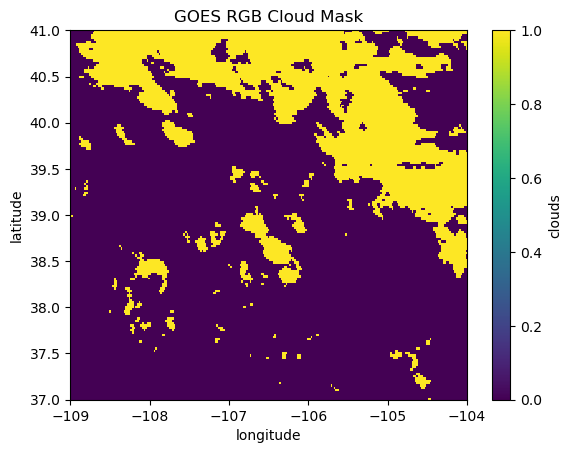

In [33]:
may_mask = ((new_ds.red <= 0.23) & (new_ds.blue >= 0.26) | ((new_ds.red > 0.23) & (new_ds.blue >= 0.16)))
summer_mask = (new_ds.red>0.07) & (new_ds.green>0.19)
winter_mask = (new_ds.red>0.39) & (new_ds.blue>0.13)
clouds = xr.where(winter_mask, 1, 0) # cloud (1) if all conds are met, not cloud (0) otherwise
new_ds['clouds'] = clouds
new_ds['goes_clouds'] = xr.where((new_ds['ACM'] == 3) | (new_ds['ACM'] == 2), 1, 0)
comparison_time = '2023-05-04 18:00:00'


new_ds.sel(t=comparison_time, method='nearest').clouds.plot.imshow(x='longitude', y='latitude')
plt.title('GOES RGB Cloud Mask')

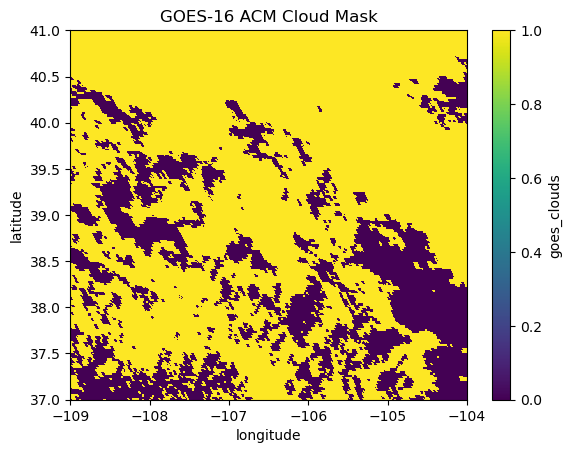

In [34]:
new_ds.sel(t=comparison_time, method='nearest').goes_clouds.plot.imshow(x='longitude', y='latitude')

plt.title("GOES-16 ACM Cloud Mask")
plt.show()

In [27]:
# Define the towns and peaks data
locations = [
    # Towns
    {"lon": -106.9886, "lat": 38.958, "label": "Gothic", "marker": "x"},
    {"lon": -106.984, "lat": 38.87, "label": "CB", "marker": "x"},
    {"lon": -106.926, "lat": 38.545, "label": "Gunnison", "marker": "x"},
    {"lon": -106.822, "lat": 39.19, "label": "Aspen", "marker": "x"},
    # Peaks
    {"lon": -107.199, "lat": 38.718, "label": "West Elk", "marker": "triangle-up-open"},
    {"lon": -106.989, "lat": 39.071, "label": "Maroon Pk", "marker": "triangle-up-open"},
    {"lon": -107.281, "lat": 39.037, "label": "Ragged Pk", "marker": "triangle-up-open"},
    {"lon": -107.383, "lat": 38.812, "label": "Mt. Gunnison", "marker": "triangle-up-open"},
]

dif_snapshot = new_ds.sel(t=comparison_time, method='nearest').goes_clouds - new_ds.sel(t=comparison_time, method='nearest').clouds


In [14]:
# Assuming dif_snapshot is an xarray DataArray
fig = px.imshow(
    dif_snapshot,
    x=dif_snapshot.longitude,
    y=dif_snapshot.latitude,
    color_continuous_scale='picnic',
    labels={'color': 'Difference'},
    title=f'Cloud Mask Difference<br>Yellow=GOES ACM cloudier<br>Red=Clintons mask cloudier<br>{comparison_time}'
)

# Add markers and labels for towns and peaks
for loc in locations:
    fig.add_trace(go.Scatter(
        x=[loc["lon"]],
        y=[loc["lat"]],
        mode="markers+text",
        marker=dict(symbol=loc["marker"], size=10, color="black"),
        text=[loc["label"]],
        textposition="top right",
        name=loc["label"]
    ))

# Customize layout
fig.update_layout(
    xaxis_title="Longitude",
    yaxis_title="Latitude",
    showlegend=False  # Hide legend if not needed
)

# Show the interactive plot
fig.show()

In [20]:
dif = new_ds.goes_clouds - new_ds.clouds

dif.compute()
dif

<xarray.DataArray (t: 95, latitude: 640, longitude: 966)> Size: 470MB
array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
...
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]], shape=(95, 640, 966))
Coordinates:
  * t          (t) datetime64[ns] 760B 2023-01-02T16:07:30 ... 2023-01-02T23:...
  * latitude   (latitude) float64 5kB 41.0 40.99 40.99 ... 37.01 37.01 37.0
  * longitude  (longitude) float64 8kB -109.0 -109.0 -109.0 ... -104.0 -104.0

In [ ]:
import imageio

# Output GIF path
output_gif = "./gifs/goes_difference_plot_20230102.gif"

# Create a list to store the generated frames
frames = []
temp_files = []

# Loop through all timesteps in the dataset
for t in dif.t.values:
    # Parse the datetime object from the string
    dt = datetime.strptime(str(t).split(".")[0], "%Y-%m-%dT%H:%M:%S")
    
    # Subtract 2 minutes using timedelta
    adjusted_time = dt - timedelta(minutes=2)
    
    # Format the adjusted time back to the desired string format
    adjusted_time_str = adjusted_time.strftime("%Y%m%d %H:%M")
    
    print(f'working on {adjusted_time_str}')
    # Plot the difference
    fig, ax = plt.subplots(figsize=(8, 6))
    im = dif.sel(t=t).plot.imshow(x='longitude', y='latitude', cmap='coolwarm', ax=ax)

    ax.set_title(f"GOES ACM Mask minus RGB-derived mask\n{adjusted_time_str} UTC")
    
    # Sanitize the timestamp for the file name
    sanitized_t = str(t).replace(":", "-")
    temp_file = f"./plots/frame_{sanitized_t}.png"
    plt.savefig(temp_file)
    plt.close(fig)

    # Append the frame to the list
    frames.append(imageio.imread(temp_file))
    temp_files.append(temp_file)

# Save all frames as a GIF
imageio.mimsave(output_gif, frames, fps=10)  # Adjust FPS as needed

print(f"GIF saved to: {output_gif}")
# Delete temporary files
for temp_file in temp_files:
    os.remove(temp_file)
    print(f"Deleted: {temp_file}")

working on 20230102 16:05


/tmp/ipykernel_787271/3970519692.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(temp_file))


working on 20230102 16:10
working on 20230102 16:15
working on 20230102 16:20
working on 20230102 16:25
working on 20230102 16:30
working on 20230102 16:35
working on 20230102 16:40
working on 20230102 16:45
working on 20230102 16:50
working on 20230102 16:55
working on 20230102 17:00
working on 20230102 17:05
working on 20230102 17:10
working on 20230102 17:15
working on 20230102 17:20
working on 20230102 17:25
working on 20230102 17:30
working on 20230102 17:35
working on 20230102 17:40
working on 20230102 17:45
working on 20230102 17:50
working on 20230102 17:55
working on 20230102 18:00
working on 20230102 18:05
working on 20230102 18:10
working on 20230102 18:15
working on 20230102 18:20
working on 20230102 18:25
working on 20230102 18:30
working on 20230102 18:35
working on 20230102 18:40
working on 20230102 18:45
working on 20230102 18:50
working on 20230102 18:55
working on 20230102 19:00
working on 20230102 19:05
working on 20230102 19:10
working on 20230102 19:15
working on 2

## Process fractional cloud cover

In [55]:
start_time = "2023-05-01"
end_time = "2023-05-31"

# Convert start_time and end_time to numpy.datetime64
start_time = np.datetime64(start_time)
end_time = np.datetime64(end_time)
tsi_ds = xr.open_dataset('/storage/cdalden/goes/surface_obs/sail_total_sky_imager/tsi_skycover_20210901_20230616.nc')
# Select time range and filter between 8am local and 6pm local (MDT) in one step
tsi_ds = tsi_ds.sel(
    time=tsi_ds['time'].where(
        (tsi_ds['time'] >= start_time) & 
        (tsi_ds['time'] <= end_time) & 
        (tsi_ds['time'].dt.hour >= 14)
    ).dropna('time')
)

da_percent_opaque =  tsi_ds['percent_opaque']
da_percent_opaque

<xarray.DataArray 'percent_opaque' (time: 33716)> Size: 135kB
[33716 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 270kB 2023-05-01T14:00:00 ... 2023-05-30T2...
Attributes:
    long_name:   Percent opaque cloud
    units:       %
    valid_min:   0.0
    valid_max:   100.0
    resolution:  1.0

In [56]:
path = '/storage/cdalden/goes/colorado/goes16/rgb_composite/'
file = 'combined_goes16_C02_C05_C13_rgb_colorado_202305.nc'

rgb_ds = xr.open_dataset(path + file)

may_mask = ((rgb_ds['red'] <= 0.23) & (rgb_ds['blue'] >= 0.26)) | ((rgb_ds['red'] > 0.23) & (rgb_ds['blue'] >= 0.16))
summer_mask = (rgb_ds['red'] > 0.07) & (rgb_ds['green'] > 0.19)
winter_mask = (rgb_ds['red'] > 0.39) & (rgb_ds['blue'] > 0.13)
month = '5'
if month in ['1', '2']:
    rgb_ds['rgb_cloud_frac'] = winter_mask.astype(int)
elif month in ['4', '5']:
    rgb_ds['rgb_cloud_frac'] = may_mask.astype(int)
elif month in ['6', '7', '8']:
    rgb_ds['rgb_cloud_frac'] = summer_mask.astype(int)


### ACM cloud fraction

In [57]:
combined_ds_gothic = combined_ds.sel(
    latitude=slice(39.065, 38.904),
    longitude=slice(-107.08, -106.993))

goes_acm_gothic_ds = xr.where((combined_ds_gothic == 3) | (combined_ds_gothic == 2), 0, 1)

### Plot cloud fractions

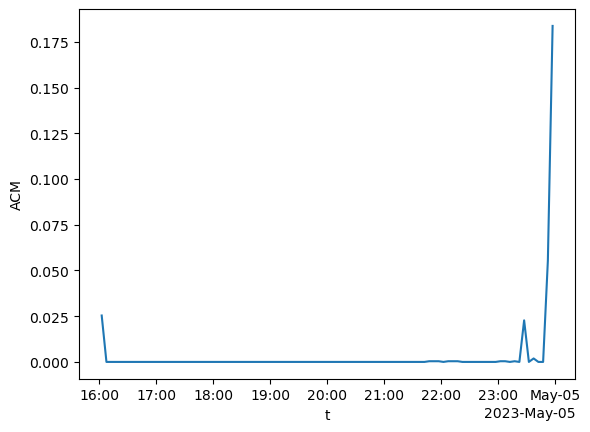

In [63]:
goes_acm_gothic_cf = goes_acm_gothic_ds.mean(dim=["latitude", "longitude"], skipna=True)
rgb_ds_cf = rgb_ds.mean(dim=["latitude", "longitude"], skipna=True)
goes_acm_gothic_cf.ACM.plot()

In [64]:
# Convert DataArrays to pandas Series
goes_series = goes_acm_gothic_cf.ACM.to_series()
rgb_series = rgb_ds_cf.rgb_cloud_frac.to_series()
opaque_series = da_percent_opaque.to_series()/100

# Combine into a DataFrame
df = (
    pd.concat([
        goes_series.rename("GOES ACM"),
        rgb_series.rename("RGB Cloud Fraction"),
        opaque_series.rename("Percent Opaque")
    ], axis=1)
    .reset_index()
)

# Plot with Plotly
fig = px.line(
    df,
    x=df.columns[0],  # Assuming the first column is time
    y=["GOES ACM", "RGB Cloud Fraction", "Percent Opaque"],
    labels={"value": "Cloud Fraction", "index": "Time"},
    title="Cloud Fraction Time Series"
)
fig.show()

In [70]:
df

index  GOES ACM  RGB Cloud Fraction  Percent Opaque
0     2023-05-01 00:02:30       NaN            0.145882             NaN
1     2023-05-01 00:07:30       NaN            0.174118             NaN
2     2023-05-01 00:12:30       NaN            0.244706             NaN
3     2023-05-01 00:17:30       NaN            0.183529             NaN
4     2023-05-01 00:22:30       NaN            0.207059             NaN
...                   ...       ...                 ...             ...
39364 2023-05-31 23:37:30       NaN            1.000000             NaN
39365 2023-05-31 23:42:30       NaN            1.000000             NaN
39366 2023-05-31 23:47:30       NaN            1.000000             NaN
39367 2023-05-31 23:52:30       NaN            0.960000             NaN
39368 2023-05-31 23:57:30       NaN            0.898824             NaN

[39369 rows x 4 columns]

KeyError: 'index'

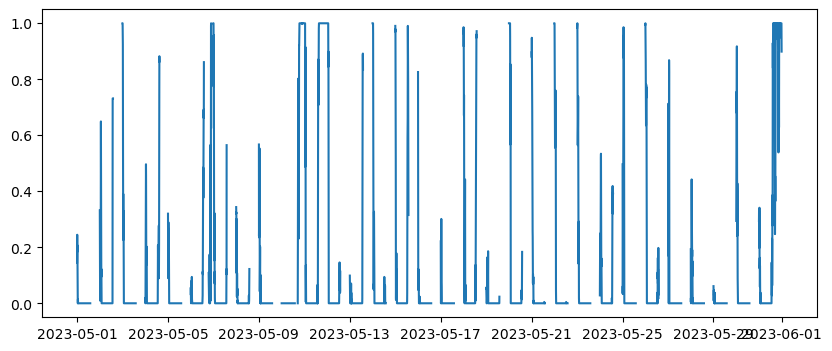

In [73]:
series = df['RGB Cloud Fraction']
nan_mask = series.isna()

plt.figure(figsize=(10, 4))
plt.plot(df['index'], series, label='RGB Cloud Fraction')
plt.scatter(series['index'][nan_mask], [np.nanmax(series)]*nan_mask.sum(), color='red', marker='x', label='NaN timestep')
plt.legend()
plt.title('RGB Cloud Fraction with NaN Timesteps Highlighted')
# plt.xlim(5000,6000)

## Analyze binary clouds for all 3 data sources

In [51]:
# Define the directory containing the CSV files
directory = "/storage/cdalden/goes/colorado/goes16/east_river_cloud_binary/"

# Use glob to find all CSV files in the directory
csv_files = glob.glob(os.path.join(directory, "*.csv"))

# Read and combine all CSV files into one DataFrame
processed_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
processed_df['cloud_binary'] = processed_df['cloud_binary'].astype('int64')
processed_df = processed_df[processed_df['goes_acm_cloud'] != 4]
processed_df.drop(columns=['Unnamed: 0'], inplace=True)
processed_df.set_index('time', inplace=True)
processed_df.index = pd.to_datetime(processed_df.index)
processed_df = processed_df[(processed_df.index.month == 2) | processed_df.index.month == 1]
# processed_df = processed_df[processed_df.index.month == 5]

/tmp/ipykernel_1239357/4204488799.py:8: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [52]:
# Create the figure
fig = go.Figure()

# Add traces for each dataset
fig.add_trace(go.Scatter(x=processed_df.index, y=processed_df.cloud_binary, mode='lines', name='TSI'))
fig.add_trace(go.Scatter(x=processed_df.index, y=processed_df.rgb_cloud_binary, mode='lines', name='RGB-derived', line=dict(dash='dash', color='green')))
fig.add_trace(go.Scatter(x=processed_df.index, y=processed_df.goes_acm_cloud, mode='lines', name='GOES ACM', line=dict(dash='dot', color='sienna')))

# Update layout
fig.update_layout(
    title='Comparison of Cloud Binary Data',
    xaxis_title='Time',
    yaxis_title='Cloud Binary',
    legend_title='Legend',
    width=1000,
    height=600
)

# Show the figure
fig.show()


In [53]:
print(processed_df['cloud_binary'].unique())
print(processed_df['rgb_cloud_binary'].unique())
print(processed_df['goes_acm_cloud'].unique())

[1 0]
[1 0]
[1 0]


RGB-derived: Balanced Accuracy = 0.97, F1 Score = 0.97
GOES ACM: Balanced Accuracy = 0.85, F1 Score = 0.90


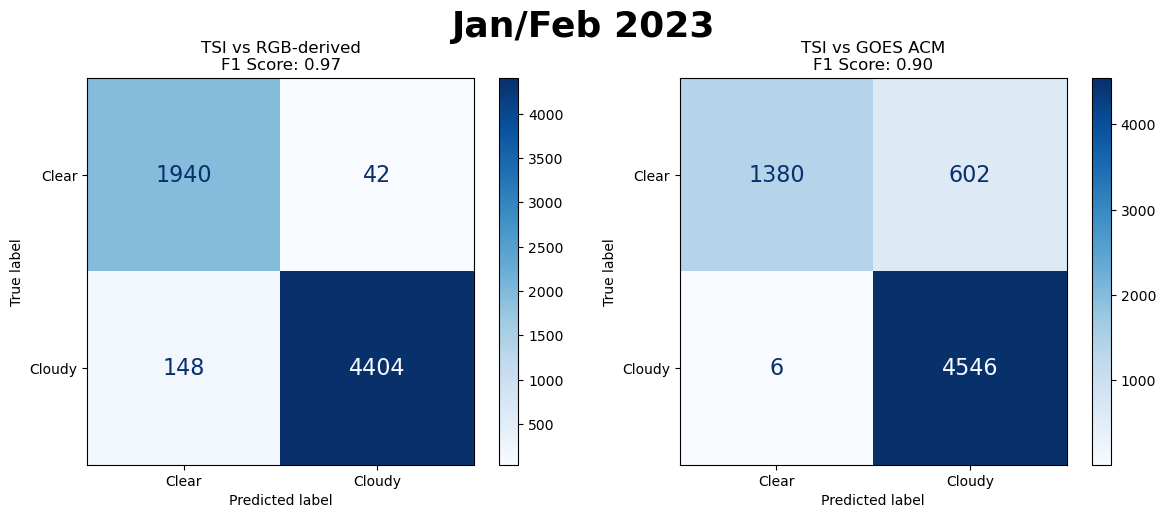

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, f1_score

# Drop rows with missing values
processed_df = processed_df.dropna(subset=['cloud_binary', 'rgb_cloud_binary', 'goes_acm_cloud'])
processed_df['cloud_binary'] = processed_df['cloud_binary'].astype(int)
processed_df['rgb_cloud_binary'] = processed_df['rgb_cloud_binary'].astype(int)
processed_df['goes_acm_cloud'] = processed_df['goes_acm_cloud'].astype(int)


# Get unique classes from the ground truth (TSI)
unique_classes = sorted(processed_df.cloud_binary.unique())
class_labels = ['Clear', 'Cloudy'][:len(unique_classes)]  # Adjust labels dynamically

# Compute confusion matrices
cm_rgb = confusion_matrix(processed_df.cloud_binary, processed_df.rgb_cloud_binary, labels=[0, 1])
cm_goes = confusion_matrix(processed_df.cloud_binary, processed_df.goes_acm_cloud, labels=[0, 1])

# Compute Balanced Accuracy and F1 scores
ba_rgb = balanced_accuracy_score(processed_df.cloud_binary, processed_df.rgb_cloud_binary)
f1_rgb = f1_score(processed_df.cloud_binary, processed_df.rgb_cloud_binary, average='weighted')

ba_goes = balanced_accuracy_score(processed_df.cloud_binary, processed_df.goes_acm_cloud)
f1_goes = f1_score(processed_df.cloud_binary, processed_df.goes_acm_cloud, average='weighted')

# Print scores
print(f"RGB-derived: Balanced Accuracy = {ba_rgb:.2f}, F1 Score = {f1_rgb:.2f}")
print(f"GOES ACM: Balanced Accuracy = {ba_goes:.2f}, F1 Score = {f1_goes:.2f}")

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# RGB-derived confusion matrix
disp_rgb = ConfusionMatrixDisplay(cm_rgb, display_labels=class_labels)
disp_rgb.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'TSI vs RGB-derived\nF1 Score: {f1_rgb:.2f}')

# Increase font size for numbers in the RGB confusion matrix
for text in disp_rgb.ax_.texts:
    text.set_fontsize(16)

# GOES ACM confusion matrix
disp_goes = ConfusionMatrixDisplay(cm_goes, display_labels=class_labels)
disp_goes.plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title(f'TSI vs GOES ACM\nF1 Score: {f1_goes:.2f}')

# Increase font size for numbers in the GOES confusion matrix
for text in disp_goes.ax_.texts:
    text.set_fontsize(16)

fig.suptitle('Jan/Feb 2023', fontweight='bold', fontsize=26)
plt.tight_layout()
